## Sentiment Classification 

In this notebook, I will use a neural network built from scratch in Python to cover some of the basics of natural language processing, and working with text in neural networks. 

### Curating the Dataset

In [1]:
f = open('reviews.txt', 'r')
reviews = list(map(lambda x:x[:-1], f.readlines()))
f.close()

f = open('labels.txt', 'r')
labels = list(map(lambda x:x[:-1], f.readlines())) 
f.close()

**NOTE** - The data in `reviews.txt` is already preprocessed and only contains lowercase characters.

In [2]:
len(reviews)

25000

In [3]:
reviews[0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '

In [4]:
labels[0]

'positive'

### Using Word Counts as Features 

In [5]:
from collections import Counter
import numpy as np

In [6]:
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [7]:
for i in range(len(reviews)):
    if(labels[i] == 'positive'):
        for word in reviews[i].split(" "):
            positive_counts[word] += 1
            total_counts[word] += 1
    else:
        for word in reviews[i].split(" "):
            negative_counts[word] += 1
            total_counts[word] += 1

### Positive to Negative Word Ratios

In [8]:
pos_neg_ratios = Counter()

for term, cnt in list(total_counts.most_common()):
    if cnt > 100:
        pos_neg_ratio = positive_counts[term]/float(negative_counts[term] + 1)
        pos_neg_ratios[term] = pos_neg_ratio

for word, ratio in pos_neg_ratios.most_common():
    if ratio > 1:
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = -np.log(1/(ratio + 0.01))

### Transforming Text into Numbers

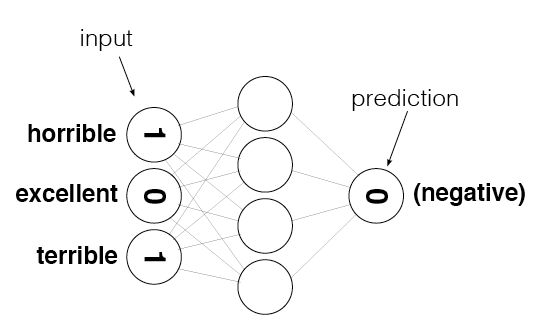

In [9]:
from IPython.display import Image

review = "this was a horrible, terrible movie"

Image(filename = 'sentiment_network.png')

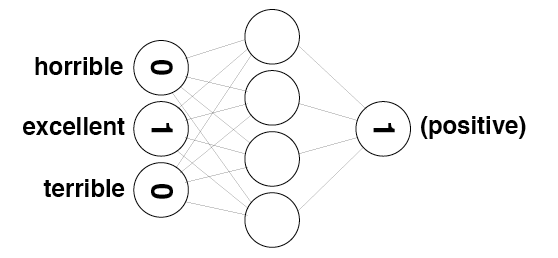

In [10]:
review = "The movie was excellent"

Image(filename = 'sentiment_network_pos.png')

### Creating the Input/Output Data

In [11]:
vocab = set(total_counts.keys())
vocab_size = len(vocab)
vocab_size

74074

In [12]:
layer_0 = np.zeros((1, vocab_size))
layer_0

array([[0., 0., 0., ..., 0., 0., 0.]])

In [13]:
word2index = {}

for i, word in enumerate(vocab):
    word2index[word] = i

word2index

{'': 0,
 'tarkovski': 1,
 'franciosa': 2,
 'paced': 3,
 'portmanteau': 4,
 'hollywod': 5,
 'televised': 6,
 'kablooey': 7,
 'inning': 8,
 'manifest': 9,
 'mumy': 10,
 'lowe': 11,
 'morven': 12,
 'donuts': 13,
 'ikiru': 14,
 'deviating': 15,
 'applies': 16,
 'penislized': 17,
 'conservator': 18,
 'chema': 19,
 'schamus': 20,
 'telepathically': 21,
 'everly': 22,
 'congregates': 23,
 'asking': 24,
 'aberrations': 25,
 'filmdirector': 26,
 'readable': 27,
 'impossible': 28,
 'unstrained': 29,
 'heavyweights': 30,
 'practitioner': 31,
 'scoped': 32,
 'vachon': 33,
 'leonie': 34,
 'compensation': 35,
 'langoria': 36,
 'anamorphic': 37,
 'schooldays': 38,
 'lackawanna': 39,
 'unsettles': 40,
 'oneyes': 41,
 'resurrect': 42,
 'sententious': 43,
 'planetscapes': 44,
 'rays': 45,
 'wormwood': 46,
 'indendoes': 47,
 'juxtapositions': 48,
 'jazzing': 49,
 'prophesies': 50,
 'roswell': 51,
 'trafficked': 52,
 'brushes': 53,
 'mp': 54,
 'dreamworld': 55,
 'misfired': 56,
 'dard': 57,
 'rayford': 58

In [14]:
def update_input_layer(review):
    global layer_0
    
    ## Clear out the previous state, reset the layer to 0s
    layer_0 *= 0
    for word in review.split(" "):
        layer_0[0][word2index[word]] += 1

update_input_layer(reviews[0])        

In [15]:
layer_0

array([[18.,  0.,  0., ...,  0.,  0.,  0.]])

In [16]:
def get_target_for_label(label):
    if(label == 'positive'):
        return 1
    else:
        return 0

In [17]:
get_target_for_label(labels[0]), labels[0]

(1, 'positive')

### Building the Neural Network

A simple 3-layered network with no non-linearity in hidden layer

In [18]:
import sys
import time

class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.01):
        """
            Creates a sentiment classification neural network
        Args:
            reviews(list) - List of reviews used for training the network
            labels(list) - List of pos/neg labels associated with the given reviews
            hidden_nodes(int) - The number of nodes in the hidden layer
            learning_rate(float) - The learning rate used while training the network
        """
        
        # Preprocesssing the reviews and labels so that everything is ready for training
        self.preprocess(reviews, labels)
        
        # Building the network as per the configuration defined 
        self.init_network(self.review_vocab_size, hidden_nodes, 1, learning_rate)

    def preprocess(self, reviews, labels):
        
        # Initialize and populate reviews and labels vocab sets
        review_vocab = set()
        for review in reviews:
            for word in review.split(' '):
                review_vocab.add(word)
        
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        self.label_vocab = list(label_vocab)
        
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Creating dictionaries of words and labesl mapped with indices
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
        
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))
    
        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # The input layer, a two-dimensional matrix with shape 1 x input_nodes
        self.layer_0 = np.zeros((1,input_nodes))    
        
    def update_input_layer(self, review):
        self.layer_0 *= 0
        
        for word in review.split(" "):
            if word in self.word2index.keys():
                self.layer_0[0][self.word2index[word]] += 1
    
    def get_target_value(self, label):
        if label == 'positive':
            return 1
        else:
            return 0
    
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)
    
    def train(self, training_reviews, training_labels):
        
        assert(len(training_reviews) == len(training_labels))
        
        correct_preds = 0
        
        start_time = time.time()
        
        # Loop through all given reviews and run a forward and backward pass, updating
        # weights each time
        for i in range(len(training_reviews)):
            review = training_reviews[i]
            label = training_labels[i]
            
            ## FORWARD PASS ##
            
            # Input layer
            self.update_input_layer(review)
            
            # Hidden layer
            layer_1 = self.layer_0.dot(self.weights_0_1)
            
            # Output layer
            layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
            
            ## BACKWARD PASS ##
            
            # Output error
            layer_2_error = layer_2 - self.get_target_value(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T)
            layer_1_delta = layer_1_error  ### No non-linearity
            
            # Update the weights
            self.weights_1_2 -= layer_1.T.dot(layer_2_delta) * self.learning_rate
            self.weights_0_1 -= self.layer_0.T.dot(layer_1_delta) * self.learning_rate
            
            if layer_2>=0.5 and label == 'positive':
                correct_preds += 1
            elif layer_2<0.5 and label == 'negative':
                correct_preds += 1
            
            elapsed_time = float(time.time() - start_time)
            reviews_per_second = i / elapsed_time if elapsed_time >0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_preds) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_preds * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
                
    def test(self, testing_reviews, testing_labels):
        correct_preds = 0
        start_time = time.time()
        
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if pred == testing_labels[i]:
                correct_preds += 1
        
            elapsed_time = float(time.time() - start_time)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_preds) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct_preds * 100 / float(i+1))[:4] + "%")
            
    def run(self, review):
        # Run the forward pass like in training function
        
        # Input layer
        self.update_input_layer(review.lower())
        
        # Hidden layer
        layer_1 = self.layer_0.dot(self.weights_0_1)
        
        # Output layer
        layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
        
        if layer_2[0] >= 0.5:
            return "positive"
        else:
            return "negative"

### Testing our Network

In [19]:
network = SentimentNetwork(reviews[:-1000], labels[:-1000], learning_rate = 0.1)

In [20]:
network.test(reviews[-1000:], labels[-1000:])

Progress:11.8% Speed(reviews/sec):575.4 #Correct:60 #Tested:119 Testing Accuracy:50.4%

Progress:99.9% Speed(reviews/sec):527.2 #Correct:500 #Tested:1000 Testing Accuracy:50.0%

In [21]:
# Train the network
network.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):119.0 #Correct:1251 #Trained:2501 Training Accuracy:50.0%
Progress:20.8% Speed(reviews/sec):122.8 #Correct:2501 #Trained:5001 Training Accuracy:50.0%
Progress:31.2% Speed(reviews/sec):127.3 #Correct:3751 #Trained:7501 Training Accuracy:50.0%
Progress:41.6% Speed(reviews/sec):131.7 #Correct:5001 #Trained:10001 Training Accuracy:50.0%
Progress:52.0% Speed(reviews/sec):135.0 #Correct:6251 #Trained:12501 Training Accuracy:50.0%
Progress:62.5% Speed(reviews/sec):130.9 #Correct:7501 #Trained:15001 Training Accuracy:50.0%
Progress:72.9% Speed(reviews/sec):131.3 #Correct:8751 #Trained:17501 Training Accuracy:50.0%
Progress:83.3% Speed(reviews/sec):133.7 #Correct:10001 #Trained:20001 Training Accuracy:50.0%
Progress:93.7% Speed(reviews/sec):135.3 #Correct:11251 #Trained:22501 Training Accuracy:50.0%
Progress:99.9% Speed(reviews/sec):133.3 #Correct:12000 #Trained:24000 Training Ac

In [22]:
network = SentimentNetwork(reviews[:-1000], labels[:-1000], learning_rate = 0.01)

In [23]:
network.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):99.77 #Correct:1243 #Trained:2501 Training Accuracy:49.7%
Progress:20.8% Speed(reviews/sec):110.8 #Correct:2491 #Trained:5001 Training Accuracy:49.8%
Progress:31.2% Speed(reviews/sec):117.7 #Correct:3739 #Trained:7501 Training Accuracy:49.8%
Progress:41.6% Speed(reviews/sec):122.2 #Correct:4989 #Trained:10001 Training Accuracy:49.8%
Progress:52.0% Speed(reviews/sec):123.7 #Correct:6239 #Trained:12501 Training Accuracy:49.9%
Progress:62.5% Speed(reviews/sec):124.9 #Correct:7489 #Trained:15001 Training Accuracy:49.9%
Progress:72.9% Speed(reviews/sec):125.4 #Correct:8739 #Trained:17501 Training Accuracy:49.9%
Progress:83.3% Speed(reviews/sec):126.5 #Correct:9989 #Trained:20001 Training Accuracy:49.9%
Progress:93.7% Speed(reviews/sec):127.2 #Correct:11239 #Trained:22501 Training Accuracy:49.9%
Progress:99.9% Speed(reviews/sec):127.5 #Correct:11988 #Trained:24000 Training Acc

In [24]:
network = SentimentNetwork(reviews[:-1000], labels[:-1000], learning_rate = 0.001)

In [25]:
network.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):138.2 #Correct:1302 #Trained:2501 Training Accuracy:52.0%
Progress:20.8% Speed(reviews/sec):142.3 #Correct:2787 #Trained:5001 Training Accuracy:55.7%
Progress:31.2% Speed(reviews/sec):130.9 #Correct:4351 #Trained:7501 Training Accuracy:58.0%
Progress:41.6% Speed(reviews/sec):134.2 #Correct:6025 #Trained:10001 Training Accuracy:60.2%
Progress:52.0% Speed(reviews/sec):136.3 #Correct:7688 #Trained:12501 Training Accuracy:61.4%
Progress:62.5% Speed(reviews/sec):138.1 #Correct:9376 #Trained:15001 Training Accuracy:62.5%
Progress:72.9% Speed(reviews/sec):138.9 #Correct:11073 #Trained:17501 Training Accuracy:63.2%
Progress:83.3% Speed(reviews/sec):139.6 #Correct:12887 #Trained:20001 Training Accuracy:64.4%
Progress:93.7% Speed(reviews/sec):140.2 #Correct:14694 #Trained:22501 Training Accuracy:65.3%
Progress:99.9% Speed(reviews/sec):140.6 #Correct:15823 #Trained:24000 Training A

### Reducing Noise in Our Input Data

In the input data, we used number of occurences of words in our input data, which makes the weights larger for mostly filler and irrelevant words, and thus our network does not improve significantly after training and tweaking the alpha.

Here, we will assign the number 1 to each word, no matter how many times it repeats in the text to not give unnecessary high weights to irrelevant data.

In [26]:
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, learning_rate = 0.01):
        """
            Creates a sentiment classification neural network
        Args:
            reviews(list) - List of reviews used for training the network
            labels(list) - List of pos/neg labels associated with the given reviews
            hidden_nodes(int) - The number of nodes in the hidden layer
            learning_rate(float) - The learning rate used while training the network
        """
        
        # Preprocesssing the reviews and labels so that everything is ready for training
        self.preprocess(reviews, labels)
        
        # Building the network as per the configuration defined 
        self.init_network(self.review_vocab_size, hidden_nodes, 1, learning_rate)

    def preprocess(self, reviews, labels):
        
        # Initialize and populate reviews and labels vocab sets
        review_vocab = set()
        for review in reviews:
            for word in review.split(' '):
                review_vocab.add(word)
        
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        self.label_vocab = list(label_vocab)
        
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Creating dictionaries of words and labesl mapped with indices
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
        
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))
    
        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # The input layer, a two-dimensional matrix with shape 1 x input_nodes
        self.layer_0 = np.zeros((1,input_nodes))    
        
    ### Noise is reduced in the input layer here ###
    def update_input_layer(self, review):
        self.layer_0 *= 0
        
        for word in review.split(" "):
            if word in self.word2index.keys():
                self.layer_0[0][self.word2index[word]] = 1
    
    def get_target_value(self, label):
        if label == 'positive':
            return 1
        else:
            return 0
    
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self, output):
        return output * (1 - output)
    
    def train(self, training_reviews, training_labels):
        
        assert(len(training_reviews) == len(training_labels))
        
        correct_preds = 0
        
        start_time = time.time()
        
        # Loop through all given reviews and run a forward and backward pass, updating
        # weights each time
        for i in range(len(training_reviews)):
            review = training_reviews[i]
            label = training_labels[i]
            
            ## FORWARD PASS ##
            
            # Input layer
            self.update_input_layer(review)
            
            # Hidden layer
            layer_1 = self.layer_0.dot(self.weights_0_1)
            
            # Output layer
            layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
            
            ## BACKWARD PASS ##
            
            # Output error
            layer_2_error = layer_2 - self.get_target_value(label)
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)
            
            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T)
            layer_1_delta = layer_1_error  ### No non-linearity
            
            # Update the weights
            self.weights_1_2 -= layer_1.T.dot(layer_2_delta) * self.learning_rate
            self.weights_0_1 -= self.layer_0.T.dot(layer_1_delta) * self.learning_rate
            
            if layer_2>=0.5 and label == 'positive':
                correct_preds += 1
            elif layer_2<0.5 and label == 'negative':
                correct_preds += 1
            
            elapsed_time = float(time.time() - start_time)
            reviews_per_second = i / elapsed_time if elapsed_time >0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_preds) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_preds * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
                
    def test(self, testing_reviews, testing_labels):
        correct_preds = 0
        start_time = time.time()
        
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if pred == testing_labels[i]:
                correct_preds += 1
        
            elapsed_time = float(time.time() - start_time)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_preds) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct_preds * 100 / float(i+1))[:4] + "%")
            
    def run(self, review):
        # Run the forward pass like in training function
        
        # Input layer
        self.update_input_layer(review.lower())
        
        # Hidden layer
        layer_1 = self.layer_0.dot(self.weights_0_1)
        
        # Output layer
        layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
        
        if layer_2[0] >= 0.5:
            return "positive"
        else:
            return "negative"

In [27]:
network = SentimentNetwork(reviews[:-1000], labels[:-1000], learning_rate = 0.1)

In [28]:
# Train the network
network.train(reviews[:-1000], labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):151.6 #Correct:1924 #Trained:2501 Training Accuracy:76.9%
Progress:20.8% Speed(reviews/sec):159.7 #Correct:3974 #Trained:5001 Training Accuracy:79.4%
Progress:31.2% Speed(reviews/sec):165.7 #Correct:6096 #Trained:7501 Training Accuracy:81.2%
Progress:41.6% Speed(reviews/sec):167.9 #Correct:8274 #Trained:10001 Training Accuracy:82.7%
Progress:52.0% Speed(reviews/sec):169.2 #Correct:10431 #Trained:12501 Training Accuracy:83.4%
Progress:62.5% Speed(reviews/sec):169.8 #Correct:12581 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):170.0 #Correct:14694 #Trained:17501 Training Accuracy:83.9%
Progress:83.3% Speed(reviews/sec):170.4 #Correct:16868 #Trained:20001 Training Accuracy:84.3%
Progress:93.7% Speed(reviews/sec):170.7 #Correct:19052 #Trained:22501 Training Accuracy:84.6%
Progress:99.9% Speed(reviews/sec):170.7 #Correct:20376 #Trained:24000 Training